# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, we build and test a `keras` dense net using intuited configurations.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black
%load_ext tensorboard

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect

# typing
from typing import Callable, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# keras & tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AlphaDropout, Dense

# visualization
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.56 s


In [4]:
# Location of cross validation .feather files
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 114 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [5]:
ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_)
        .sort_values(by=["model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "f1",
                "geometric_mean",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "accuracy",
            "adjusted_balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    return df


_ = gc_collect()

time: 116 ms


In [6]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 116 ms


# Model

In this section, we set up the MLP.

In [7]:
def make_MLP(case: str, output_bias: float, print_summary: bool = True) -> Sequential:
    """Return a prepared keras MLP"""
    if "ternary" in case:
        out_nodes, final_activation, loss, accuracy = (
            3,
            "softmax",
            "sparse_categorical_crossentropy",
            "sparse_categorical_accuracy",
        )
    else:
        out_nodes, final_activation, loss, accuracy = (
            1,
            "sigmoid",
            "binary_crossentropy",
            "binary_accuracy",
        )

    model = Sequential(
        [
            Dense(
                1024,
                input_dim=2048,
            ),
            Dense(
                out_nodes,
                activation=final_activation,
                bias_initializer=output_bias,
            ),
        ]
    )
    model.compile(
        loss=loss,
        optimizer="adam",
        metrics=accuracy,
    )
    if print_summary:
        model.summary()
    return model


_ = gc_collect()

time: 117 ms


# Test harness

This section defines functions for evaluating models.

In [8]:
recode_y: Dict[str, Callable] = {
    "negative": lambda y: ((y - 1) // 2) * (-1),
    "neutral": lambda y: y % 2,
    "positive": lambda y: y // 2,
    "ternary": lambda y: y,
}


def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = True
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""
    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(7))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        def read_feather_cv(xy_set: str) -> pd.DataFrame:
            """Helper function for reading split data"""
            path_prefix = f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{xy_set}"
            if "train" in xy_set:
                return pd.read_feather(f"{path_prefix}_untransformed.feather")
            else:
                return pd.read_feather(f"{path_prefix}_untransformed.feather")

        # load training data
        try:
            X_train: pd.DataFrame = read_feather_cv("X_train")
            y_train: np.ndarray = read_feather_cv("y_train").iloc[:, 0]
        except FileNotFoundError:
            break

        # recode/reformat y_train
        recoder = recode_y[case]
        y_train = recoder(y_train)

        # load testing data
        X_test = read_feather_cv("X_test")
        y_test = read_feather_cv("y_test").iloc[:, 0].astype(np.int8)

        # initialize model with output layer bias
        if multiclass := "ternary" in case:
            zeros, ones, twos = np.bincount(y_test)
            init_bias = tf.keras.initializers.Constant(
                np.squeeze(
                    [
                        np.log([zeros / (ones + twos)]),
                        np.log([ones / (zeros + twos)]),
                        np.log([twos / (zeros + ones)]),
                    ]
                )
            )
            del twos
        else:
            # recode y_test
            y_test = recoder(y_test)
            del recoder
            _ = gc_collect()
            zeros, ones = np.bincount(y_test)
            init_bias = tf.keras.initializers.Constant(np.log([ones / zeros]))
        del ones
        del zeros
        _ = gc_collect()

        model = make_MLP(case, output_bias=init_bias)
        del init_bias
        _ = gc_collect()

        # fit
        reset_seeds(SEED)
        begin = time()
        history = model.fit(
            X_train,
            y_train,
            # batch_size=16,
            epochs=1000,
            validation_split=0.1,
            callbacks=EarlyStopping(patience=20, restore_best_weights=True),
        )
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        pd.DataFrame(history.history).plot(
            cmap=ListedColormap(sns.color_palette("colorblind").as_hex())
        )
        plt.title("accuracy and loss by epochs")
        plt.legend(frameon=False)
        sns.despine(**dict.fromkeys(("right", "top"), True))
        plt.show()

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        y_pred = (
            predicted.argmax(axis=1)
            if multiclass
            else pd.Series(np.squeeze(predicted)).swifter.apply(round)
        ).astype(np.int8)
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=y_pred,
            ),
        )

        # score
        score_params = {
            "y_true": y_test,
            "y_pred": y_pred,
        }
        accuracy.append(accuracy_score(**score_params))
        adjusted_balanced_accuracy.append(
            balanced_accuracy_score(**score_params, adjusted=True)
        )
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))
        del y_pred
        score_params = {
            "y_true": y_test,
            "y_score": predicted,
            "average": "weighted",
            "multi_class": "ovo",
        }
        roc_auc.append(roc_auc_score(**score_params))
        del score_params
        del predicted
        del y_test
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


_ = gc_collect()

time: 113 ms


The next few cells evaluate models.

evaluating keras_MLP_14v3...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2061/2061 [==============================] - 18s 9ms/step - loss: 0.5969 - binary_accuracy: 0.6855 - val_loss: 0.7660 - val_binary_accuracy: 0.5759
Epoch 2/1000
2061/2061 [==============================] - 17s 8ms/step - loss: 0.5754 - binary_accuracy: 0.7045 - val_loss: 0.6947 - val_binary_accuracy: 0.5762
Epoch 3/1000
2061/2061 [==============================] - 17s 8ms/step - loss: 0.5668 - binary_accuracy: 0.7115 - val_loss: 0.8006 - val_binary_accuracy: 0.5

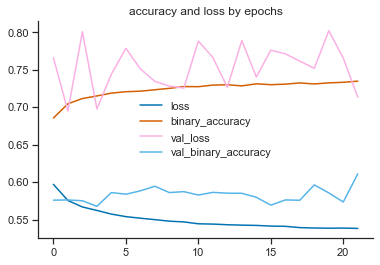

predicted in 1.47 s
keras_MLP_14v3 fold 1 completed in 426.08 s
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2116/2116 [==============================] - 20s 9ms/step - loss: 0.5998 - binary_accuracy: 0.6824 - val_loss: 0.7131 - val_binary_accuracy: 0.5604
Epoch 2/1000
2116/2116 [==============================] - 19s 9ms/step - loss: 0.5792 - binary_accuracy: 0.6989 - val_loss: 0.6921 - val_binary_accuracy: 0.5668
Epoch 3/1000
2116/2116 [==============================] - 19s 9ms/step - loss: 0.5713 - binary_accuracy: 0.7060 - val_lo

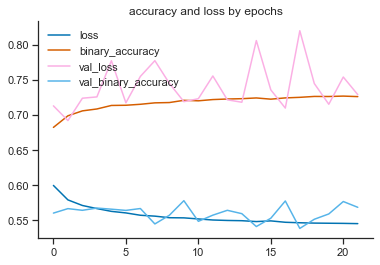

predicted in 1.24 s
keras_MLP_14v3 fold 2 completed in 443.18 s
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1897/1897 [==============================] - 19s 9ms/step - loss: 0.5972 - binary_accuracy: 0.6836 - val_loss: 0.7745 - val_binary_accuracy: 0.5572
Epoch 2/1000
1897/1897 [==============================] - 17s 9ms/step - loss: 0.5739 - binary_accuracy: 0.7048 - val_loss: 0.7779 - val_binary_accuracy: 0.5575
Epoch 3/1000
1897/1897 [==============================] - 17s 9ms/step - loss: 0.5651 - binary_accuracy: 0.7112 - val_lo

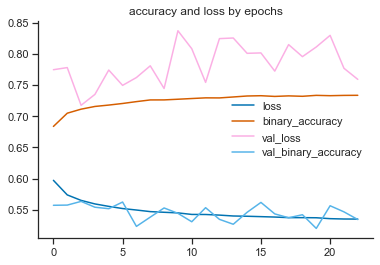

predicted in 2.06 s
keras_MLP_14v3 fold 3 completed in 411.59 s
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1712/1712 [==============================] - 16s 9ms/step - loss: 0.5871 - binary_accuracy: 0.6934 - val_loss: 0.7327 - val_binary_accuracy: 0.5768
Epoch 2/1000
1712/1712 [==============================] - 16s 10ms/step - loss: 0.5635 - binary_accuracy: 0.7123 - val_loss: 0.7708 - val_binary_accuracy: 0.5719
Epoch 3/1000
1712/1712 [==============================] - 16s 9ms/step - loss: 0.5550 - binary_accuracy: 0.7205 - val_l

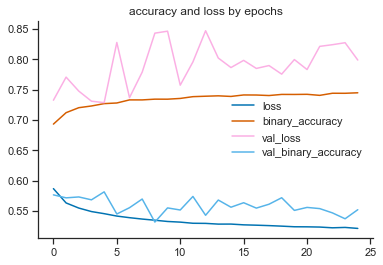

predicted in 2.73 s
keras_MLP_14v3 fold 4 completed in 399.86 s
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1975/1975 [==============================] - 19s 9ms/step - loss: 0.5903 - binary_accuracy: 0.6894 - val_loss: 0.7803 - val_binary_accuracy: 0.5580
Epoch 2/1000
1975/1975 [==============================] - 18s 9ms/step - loss: 0.5694 - binary_accuracy: 0.7070 - val_loss: 0.7187 - val_binary_accuracy: 0.5664
Epoch 3/1000
1975/1975 [==============================] - 18s 9ms/step - loss: 0.5604 - binary_accuracy: 0.7141 - val_lo

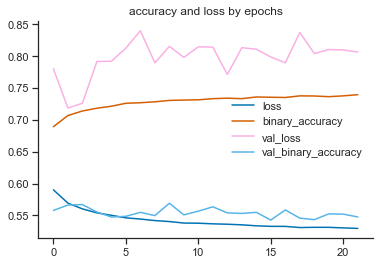

predicted in 1.72 s
keras_MLP_14v3 fold 5 completed in 401.73 s
stored keras_MLP_14v3 for negative classification in 2083.19 s


,model_name,case,accuracy,adjusted_balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,keras_MLP_14v3,negative,0.643563,0.260229,0.637732,0.617681,0.684612,412.591657,1.843707


time: 34min 43s


In [9]:
case = "negative"
model = "keras_MLP_14v3"

eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del case
del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating keras_MLP_14v3...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2061/2061 [==============================] - 19s 9ms/step - loss: 0.4099 - binary_accuracy: 0.8005 - val_loss: 0.7175 - val_binary_accuracy: 0.7565
Epoch 2/1000
2061/2061 [==============================] - 19s 9ms/step - loss: 0.3882 - binary_accuracy: 0.8155 - val_loss: 0.6764 - val_binary_accuracy: 0.7540
Epoch 3/1000
2061/2061 [==============================] - 19s 9ms/step - loss: 0.3806 - binary_accuracy: 0.8181 - val_loss: 0.7451 - val_binary_accuracy: 0

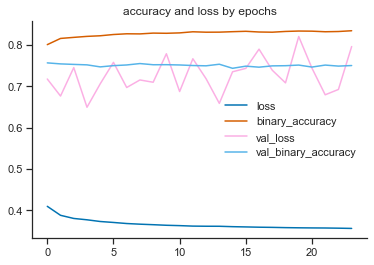

predicted in 1.45 s
keras_MLP_14v3 fold 1 completed in 461.89 s
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2116/2116 [==============================] - 20s 9ms/step - loss: 0.4200 - binary_accuracy: 0.7963 - val_loss: 0.5381 - val_binary_accuracy: 0.7835
Epoch 2/1000
2116/2116 [==============================] - 19s 9ms/step - loss: 0.3978 - binary_accuracy: 0.8094 - val_loss: 0.5391 - val_binary_accuracy: 0.7920
Epoch 3/1000
2116/2116 [==============================] - 19s 9ms/step - loss: 0.3907 - binary_accuracy: 0.8134 - val_lo

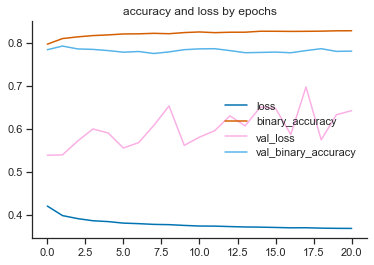

predicted in 1.22 s
keras_MLP_14v3 fold 2 completed in 396.73 s
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1897/1897 [==============================] - 17s 9ms/step - loss: 0.4003 - binary_accuracy: 0.8111 - val_loss: 0.6236 - val_binary_accuracy: 0.7823
Epoch 2/1000
1897/1897 [==============================] - 16s 8ms/step - loss: 0.3756 - binary_accuracy: 0.8243 - val_loss: 0.6062 - val_binary_accuracy: 0.7891
Epoch 3/1000
1897/1897 [==============================] - 16s 8ms/step - loss: 0.3685 - binary_accuracy: 0.8283 - val_lo

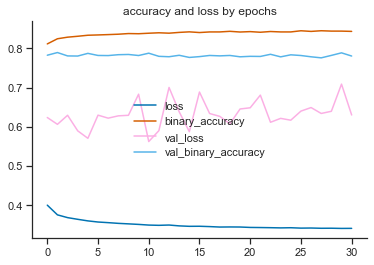

predicted in 2.05 s
keras_MLP_14v3 fold 3 completed in 496.89 s
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1712/1712 [==============================] - 15s 9ms/step - loss: 0.4041 - binary_accuracy: 0.8053 - val_loss: 0.5762 - val_binary_accuracy: 0.7728
Epoch 2/1000
1712/1712 [==============================] - 14s 8ms/step - loss: 0.3813 - binary_accuracy: 0.8184 - val_loss: 0.5777 - val_binary_accuracy: 0.7687
Epoch 3/1000
1712/1712 [==============================] - 14s 8ms/step - loss: 0.3742 - binary_accuracy: 0.8223 - val_lo

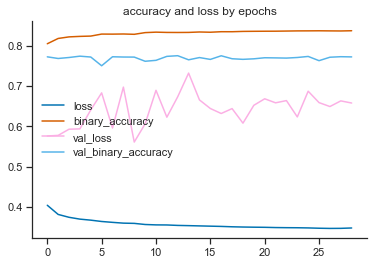

predicted in 2.66 s
keras_MLP_14v3 fold 4 completed in 420.95 s
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 1025      
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1975/1975 [==============================] - 17s 9ms/step - loss: 0.3745 - binary_accuracy: 0.8260 - val_loss: 0.5822 - val_binary_accuracy: 0.7771
Epoch 2/1000
1975/1975 [==============================] - 16s 8ms/step - loss: 0.3501 - binary_accuracy: 0.8401 - val_loss: 0.5344 - val_binary_accuracy: 0.7857
Epoch 3/1000
1975/1975 [==============================] - 17s 8ms/step - loss: 0.3419 - binary_accuracy: 0.8443 - val_lo

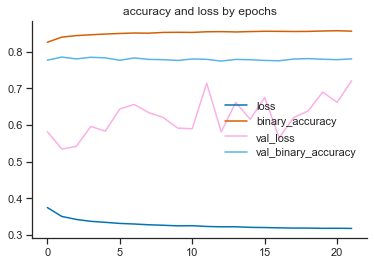

predicted in 1.69 s
keras_MLP_14v3 fold 5 completed in 369.96 s
stored keras_MLP_14v3 for neutral classification in 2147.16 s


,model_name,case,accuracy,adjusted_balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,keras_MLP_14v3,negative,0.643563,0.260229,0.637732,0.617681,0.684612,412.591657,1.843707
1,keras_MLP_14v3,neutral,0.788243,0.328888,0.771614,0.613707,0.822907,425.630495,1.815206


time: 35min 47s


In [10]:
case = "neutral"
model = "keras_MLP_14v3"

eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del case
del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

evaluating keras_MLP_14v3...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 3075      
Total params: 2,101,251
Trainable params: 2,101,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2061/2061 [==============================] - 18s 8ms/step - loss: 0.7967 - sparse_categorical_accuracy: 0.6351 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.5304
Epoch 2/1000
2061/2061 [==============================] - 17s 8ms/step - loss: 0.7572 - sparse_categorical_accuracy: 0.6587 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.5399
Epoch 3/1000
2061/2061 [==============================] - 17s 8ms/step - loss: 0.7427 - sparse_categorical

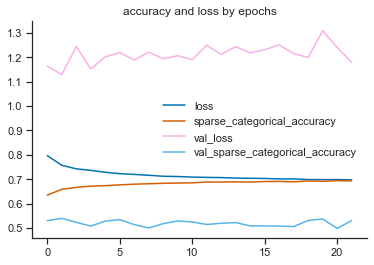

predicted in 1.40 s
keras_MLP_14v3 fold 1 completed in 383.26 s
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 3075      
Total params: 2,101,251
Trainable params: 2,101,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2116/2116 [==============================] - 18s 8ms/step - loss: 0.8069 - sparse_categorical_accuracy: 0.6294 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.5216
Epoch 2/1000
2116/2116 [==============================] - 18s 8ms/step - loss: 0.7692 - sparse_categorical_accuracy: 0.6518 - val_loss: 1.0311 - val_sparse_categorical_accuracy: 0.5208
Epoch 3/1000
2116/2116 [==============================] - 18s 8ms/step 

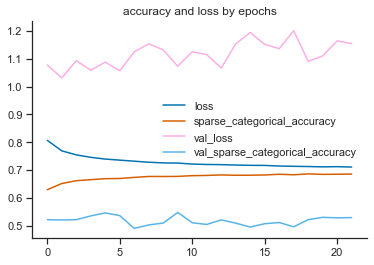

predicted in 1.22 s
keras_MLP_14v3 fold 2 completed in 393.18 s
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 3075      
Total params: 2,101,251
Trainable params: 2,101,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1897/1897 [==============================] - 16s 8ms/step - loss: 0.7869 - sparse_categorical_accuracy: 0.6449 - val_loss: 1.1179 - val_sparse_categorical_accuracy: 0.5285
Epoch 2/1000
1897/1897 [==============================] - 16s 8ms/step - loss: 0.7453 - sparse_categorical_accuracy: 0.6665 - val_loss: 1.1301 - val_sparse_categorical_accuracy: 0.5397
Epoch 3/1000
1897/1897 [==============================] - 16s 8ms/step 

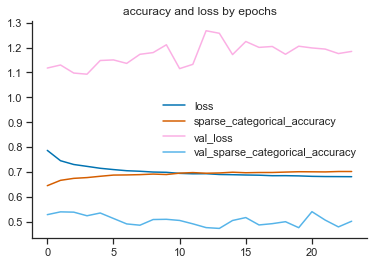

predicted in 2.01 s
keras_MLP_14v3 fold 3 completed in 383.73 s
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 3075      
Total params: 2,101,251
Trainable params: 2,101,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1712/1712 [==============================] - 15s 9ms/step - loss: 0.7824 - sparse_categorical_accuracy: 0.6446 - val_loss: 1.0066 - val_sparse_categorical_accuracy: 0.5596
Epoch 2/1000
1712/1712 [==============================] - 14s 8ms/step - loss: 0.7406 - sparse_categorical_accuracy: 0.6679 - val_loss: 1.0497 - val_sparse_categorical_accuracy: 0.5556
Epoch 3/1000
1712/1712 [==============================] - 14s 8ms/step 

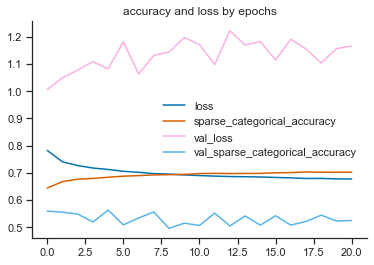

predicted in 2.65 s
keras_MLP_14v3 fold 4 completed in 305.19 s
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 3075      
Total params: 2,101,251
Trainable params: 2,101,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1975/1975 [==============================] - 17s 9ms/step - loss: 0.7593 - sparse_categorical_accuracy: 0.6564 - val_loss: 1.1434 - val_sparse_categorical_accuracy: 0.5414
Epoch 2/1000
1975/1975 [==============================] - 16s 8ms/step - loss: 0.7194 - sparse_categorical_accuracy: 0.6801 - val_loss: 1.0373 - val_sparse_categorical_accuracy: 0.5484
Epoch 3/1000
1975/1975 [==============================] - 16s 8ms/step 

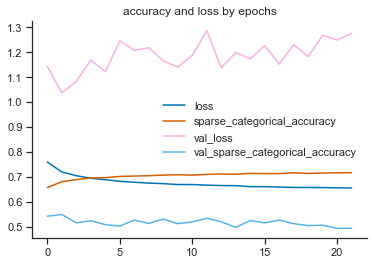

predicted in 1.70 s
keras_MLP_14v3 fold 5 completed in 366.07 s
stored keras_MLP_14v3 for ternary classification in 1832.15 s


,model_name,case,accuracy,adjusted_balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,keras_MLP_14v3,negative,0.643563,0.260229,0.637732,0.617681,0.684612,412.591657,1.843707
1,keras_MLP_14v3,neutral,0.788243,0.328888,0.771614,0.613707,0.822907,425.630495,1.815206
2,keras_MLP_14v3,ternary,0.590471,0.239971,0.567899,0.437574,0.733400,362.785909,1.795502


time: 30min 32s


In [11]:
case = "ternary"
model = "keras_MLP_14v3"

eval_begin = time()

print(f"evaluating {model}...")
_ = gc_collect()
store_result(
    where=results_,
    case=case,
    model_name=model,
    avg_scores=evaluate_model(model, case),
)
print(f"stored {model} for {case} classification in {time() - eval_begin:.2f} s")

del case
del model
del eval_begin
_ = gc_collect()

create_results_df(results_)

In [12]:
# save predictions
predictions_df = pd.DataFrame(predictions_)[["model", "case", "fold", "y_pred"]]
predictions_df.case = predictions_df.case.astype("category")
predictions_df.fold = predictions_df.fold.astype(np.uint8)
predictions_df.to_pickle(f"{DATA_OUT_FOLDER}/keras_MLPv3_14_predictions_CV5.pkl")
del predictions_df
_ = gc_collect()

time: 126 ms


Let's peek at the results.

In [13]:
results_df = create_results_df(results_)
results_df

,model_name,case,accuracy,adjusted_balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,keras_MLP_14v3,negative,0.643563,0.260229,0.637732,0.617681,0.684612,412.591657,1.843707
1,keras_MLP_14v3,neutral,0.788243,0.328888,0.771614,0.613707,0.822907,425.630495,1.815206
2,keras_MLP_14v3,ternary,0.590471,0.239971,0.567899,0.437574,0.733400,362.785909,1.795502


time: 15.6 ms


# Metaclassifier

In [27]:
pred_df = pd.DataFrame(predictions_).query(f"case != 'ternary'")[
    ["case", "fold", "y_pred"]
]
fold_df = pred_df.query(f"fold == 1").drop(columns="fold")

time: 14 ms


In [28]:
fold_df

,case,y_pred
1,negative,0 1 1 1 2 1 3 1 4 ...
6,neutral,0 0 1 0 2 0 3 0 4 ...
16,ternary_negneu,0 1 1 1 2 1 3 1 4 ...


time: 16 ms


In [31]:
def prep_y_pred(label: int) -> np.ndarray:
    """Prepares ternary labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.int8)


model_name = "keras_MLP_14v3+keras_MLP_14v3"
pred_df = pd.DataFrame(predictions_)
pred_df = pred_df.loc[pred_df.case.isin(("negative", "neutral"))][
    ["case", "fold", "y_pred"]
]
accuracy, adjusted_balanced_accuracy, f1, geometric_mean, roc_auc = (
    [] for _ in range(5)
)
for fold_num in np.unique(pred_df.fold):
    fold_df = pred_df.query(f"fold == {fold_num}").drop(columns="fold")
    query_fold = lambda case: fold_df.query(f"case == '{case}'").y_pred.item()
    df = pd.DataFrame(
        {
            "neutral_prediction": query_fold("neutral"),
            "negative_prediction": query_fold("negative"),
        }
    )
    del fold_df
    del query_fold
    _ = gc_collect()

    # "predict" 0: negative, 1: neutral, 2: positive
    df["hybrid_prediction"] = df.loc[:, "neutral_prediction"]
    df.loc[df["hybrid_prediction"] == 0, "hybrid_prediction"] = (-1) * df.loc[
        df["hybrid_prediction"] == 0, "negative_prediction"
    ] + 2
    y_pred: pd.Series = df.hybrid_prediction.astype(np.int8)
    del df
    _ = gc_collect()

    # record y_pred
    store_prediction(
        where=predictions_,
        prediction=Prediction(
            model=model_name,
            case="ternary_negneu",
            fold=fold_num,
            y_pred=y_pred,
        ),
    )

    # score
    score_params = {
        "y_true": pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/y_test_ter.feather"
        ).iloc[:, 0],
        "y_pred": y_pred,
    }
    accuracy.append(accuracy_score(**score_params))
    adjusted_balanced_accuracy.append(
        balanced_accuracy_score(**score_params, adjusted=True)
    )
    f1.append(f1_score(**score_params, average="weighted"))
    geometric_mean.append(geometric_mean_score(**score_params))
    score_params = {
        "y_true": score_params["y_true"],
        "y_score": np.stack(y_pred.swifter.apply(prep_y_pred).values),
        "average": "weighted",
        "multi_class": "ovo",
    }
    roc_auc.append(roc_auc_score(**score_params))
    del score_params
    del y_pred
    _ = gc_collect()
del pred_df
_ = gc_collect()

# helper functions
get_time = lambda case, fit_predict: results_df.query(
    f"case == '{case}' & model_name == 'keras_MLP_14v3'"
)[f"{fit_predict}_time"].item()
sum_times = lambda time_metric: get_time("negative", time_metric) + get_time(
    "neutral", time_metric
)

store_result(
    where=results_,
    case="ternary_negneu",
    model_name=model_name,
    avg_scores=AvgScores(
        np.mean(accuracy),
        np.mean(adjusted_balanced_accuracy),
        np.mean(f1),
        np.mean(geometric_mean),
        np.mean(roc_auc),
        sum_times("fit"),
        sum_times("predict"),
    ),
)

print(f"stored hybrid ternary classification results for {model_name}")

del accuracy
del adjusted_balanced_accuracy
del f1
del geometric_mean
del roc_auc
del model_name
del get_time
del sum_times
_ = gc_collect()

Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 352704.19it/s]


stored hybrid ternary classification results for keras_MLP_14v3+keras_MLP_14v3
time: 2.76 s


# Results

In [32]:
results_df = create_results_df(results_)
results_df

,model_name,case,accuracy,adjusted_balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,keras_MLP_14v3,negative,0.643563,0.260229,0.637732,0.617681,0.684612,412.591657,1.843707
1,keras_MLP_14v3,neutral,0.788243,0.328888,0.771614,0.613707,0.822907,425.630495,1.815206
2,keras_MLP_14v3,ternary,0.590471,0.239971,0.567899,0.437574,0.733400,362.785909,1.795502
3,keras_MLP_14v3+keras_MLP_14v3,ternary_negneu,0.251710,0.026479,0.157001,0.000000,0.510715,838.222152,3.658913
4,keras_MLP_14v3+keras_MLP_14v3,ternary_negneu,0.251710,0.026479,0.157001,0.000000,0.510715,838.222152,3.658913
5,keras_MLP_14v3+keras_MLP_14v3,ternary_negneu,0.251710,0.026479,0.157001,0.000000,0.510715,838.222152,3.658913


time: 25.8 ms


In [17]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/initial_MLPv3_results_CV5.csv")
_ = gc_collect()

time: 155 ms


# Discussion

hopefully good performance

In [18]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 6192.786722898483 s
time: 130 ms


[^top](#Contents)